# 2 Transaction Data
## Library Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
from functools import reduce

## 2.1 Converting txt to csv

In [2]:
#define variables
inpath = "../00_data/transdata/raw data/"
intype = ".txt"
incode = "utf-16"
outpath = "../00_data/transdata/csv/"
outtype = ".csv"
outcode = "utf-8"

#define dataselection
months = ["2017_05","2017_07","2017_10","2018_01","2018_04","2018_07"]

for m in months:
    with open (outpath + "transdata_" + m + outtype,"w",encoding=outcode) as outfile:
        infile = inpath + "transdata_" + m + intype 
        with open (infile, encoding=incode) as infile:
            for line in infile:
                outfile.write(line)

## 2.2 Editing csv-files via pandas

http://pandas.pydata.org/
- Insert header
- Clean and transform data
- Save new csv-file

In [3]:
header = ["Store","CardID","EAN","Category","MedType","SW2Key", 
          "Revenue","RevenueInc.","Qty","TransactionType","BookingDate"]
columns = [2,3,4,5,6,7,8,10,12,14,15]

In [4]:
def new_csv_after_pd (var, month):

    df = pd.read_csv(var, delimiter="\t", encoding="utf-8", header=None,
                          names=header, usecols=columns,skipfooter=1,na_filter=False,
                          skip_blank_lines = False, error_bad_lines=False, warn_bad_lines=True,
                          engine="python", decimal=",",
                          dtype={("EAN","Category","MedType","SW2Key","TransactionType"):object})
    
    df["BookingDate"] = pd.to_datetime(df["BookingDate"], format = "%d.%m.%Y" )  
    df.to_csv("../00_data/transdata/csv pd/transdata_" + month + ".csv",
              encoding="utf-8", sep=",", na_rep="NaN", index=False)

all_files = glob.glob(os.path.join(outpath, "*.csv"))

for f in all_files:
    month = f.replace(os.path.join(outpath, "transdata_"),"").replace(".csv","")
    new_csv_after_pd(f,month)

## 2.3 Merge csv-files via pandas
http://pandas.pydata.org/pandas-docs/stable/generated/pandas.concat.html    
(Attention: only works with identical column names)
- Save new csv-file

In [5]:
#define which path to choose
outpath2 = "../00_data/transdata/csv pd/"

all_files = glob.glob(os.path.join(outpath2, "*.csv"))

df_from_each_file = (pd.read_csv(f, low_memory=False) for f in all_files)
concat_df = pd.concat(df_from_each_file, ignore_index = True)

In [6]:
concat_df["BookingDate"] = pd.to_datetime(concat_df["BookingDate"],format="%Y-%m-%d")
print("Transactions: " + str(len(concat_df.index)))

Transactions: 1002


## 2.4 Data cleaning

### 2.4.1 Check transdata for blank transactions
  Check for transactions with **Qty** or **Revenue** of zero. Afterwards they will be eliminated.

In [7]:
df1 = concat_df

df_zerorev = df1.loc[df1["Revenue"] == 0]
df_zerorev.to_csv("data excluded/excluded 2_zero revenue.csv", encoding="utf-8", sep=",")
print("Transactions without rev: " + str(len(df_zerorev.index)))

Transactions without rev: 0


In [8]:
df_zeroqty = df1.loc[df1["Qty"] == 0]
df_zeroqty.to_csv("data excluded/excluded 3_zero qty.csv", encoding="utf-8", sep=",")
print("Transactions without qty: " + str(len(df_zeroqty.index)))

Transactions without qty: 0


In [9]:
#Cleaning transactions
df_exzeros = df1.loc[~(df1["Revenue"] == 0)]
df_exzeros = df_exzeros.loc[~(df_exzeros["Qty"] == 0)]
print("Transactions after cleaning: " + str(len(df_exzeros.index)))

Transactions after cleaning: 1002


### 2.4.2 Exclude returns
Check how many returns exist with **TransactionType**: **5**.

In [10]:
df2 = df_exzeros

df_ret = df2.loc[df2["TransactionType"] == 5]
df_ret.to_csv("data excluded/excluded 4_returns.csv", encoding="utf-8", sep=",")
print("Returns: " + str(len(df_ret.index)))

Returns: 52


In [11]:
#Cleaning transactions
df_exret = df2.loc[~(df2["TransactionType"] == 5)]
df_exret.to_csv("data new/transdata.csv",encoding = "utf-8",sep = ",",index = False)
print("Transactions without returns: " + str(len(df_exret.index)))

Transactions without returns: 950


In [12]:
df_exret.head()

,Store,CardID,EAN,Category,MedType,SW2Key,Revenue,RevenueInc.,Qty,TransactionType,BookingDate
0,1,27924459899,9986,1,34,22,73.06,73.06,4.0,1,2018-01-02
1,5,66736159399,9994,4,32,22,24.16,24.16,1.0,1,2018-01-02
2,7,66736159399,9997,4,32,22,57.76,57.76,1.0,1,2018-01-02
3,2,59681386599,9992,3,34,22,72.82,68.82,2.0,1,2018-01-04
4,10,65801188599,9994,4,32,22,24.16,24.16,1.0,1,2018-01-04


### 2.4.3 Analyse time dimension via tranactions

In [13]:
plt.style.use("default")

def show_hist (dataframe,var,title,labeliv,rot,output_path=None):
    g = sns.factorplot(x=var, data=dataframe.sort_values(by=var, ascending=True), kind="count",
                      palette="Blues", size=4, aspect=2)

    g.fig.suptitle(title, fontsize=12, x=0.5)
    g.set_xticklabels(step=labeliv)
    g.set_xticklabels(rotation=rot)
    
    plt.ylabel("Customers")
    
    def set_style():
        plt.style.use(["seaborn-white", "seaborn-paper"])
        plt.rc("font", family="Arial")
    
    set_style()
    plt.show()
        
    if output_path is not None:
        g.savefig(output_path,dpi=350)

In [14]:
df_exret2 = df_exret.loc[:,["BookingDate"]]
df_exret2["BookingMonth"] = df_exret2["BookingDate"].map(lambda x: x.strftime("%Y-%m"))

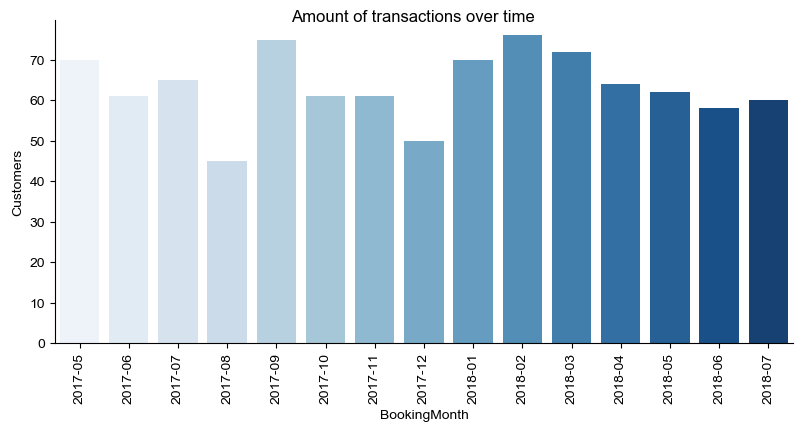

In [15]:
show_hist(df_exret2,"BookingMonth","Amount of transactions over time",1,90,
          "visualizations/transactions over time")

## 2.5 Variable engeneering

### 2.5.1 Import data

In [16]:
df_master = pd.read_csv("data new/masterdata.csv",encoding="utf-8",sep=",",
                        parse_dates=["BirthDate","ValidityDate"],dtype={"CardID":"int64",
                                                                        "CustID":object,
                                                                        "CustID old":object,
                                                                        "PostalCode":object})

### 2.5.2 Online & offline shoppers

Adding a variable which sums up the **online** purchases. Additionally inserting the **offline** stack.

**ChannelShopperDetail:**
- Online: 100% online revenue
- HybridOn: >50% online revenue
- HybridOff: <50% online revenue
- Offline: 0% online revenue

In [17]:
#define online channel
onchannel = 1

In [18]:
df_masterS = df_master.loc[:,["CustID","CardID"]]

In [19]:
df_transO = df_exret.loc[:,["CardID","Store","Revenue"]]
df_transO = df_transO.groupby(["CardID","Store"], as_index=False).agg(np.sum)
df_transO.loc[df_transO["Store"].isin([onchannel]),"OnlineRevenue"] = df_transO["Revenue"]

df_transO = pd.merge(df_transO,df_masterS,how="left",on="CardID",indicator=True)
df_transO = df_transO.loc[~(df_transO["_merge"] == "left_only")]
df_transO = df_transO.groupby(["CustID"], as_index=False).agg({"Revenue": np.sum,"OnlineRevenue": np.sum})

In [20]:
df_transOF = df_exret.loc[:,["CardID","Store","Revenue"]]
df_transOF = df_transOF.groupby(["CardID","Store"], as_index=False).agg(np.sum)
df_transOF.loc[~(df_transOF["Store"].isin([onchannel])),"OfflineRevenue"] = df_transOF["Revenue"]

df_transOF = pd.merge(df_transOF,df_masterS,how="left",on="CardID",indicator=True)
df_transOF = df_transOF.loc[~(df_transOF["_merge"] == "left_only")]
df_transOF = df_transOF.groupby(["CustID"], as_index=False).agg({"OfflineRevenue": np.sum})

In [21]:
df_transOOF = pd.merge(df_transO,df_transOF,how="left",on="CustID",indicator=False)

In [22]:
perc = df_transOOF["OnlineRevenue"]/df_transOOF["Revenue"]*100
perco = df_transOOF["OfflineRevenue"]/df_transOOF["Revenue"]*100

df_transOOF["ChannelShopper"] = np.where(perc == 100,"Online",
                                         np.where(perc > 0,"Hybrid","Offline"))

df_transOOF["ChannelShopperDetail"] = np.where(perc == 100,"Online",
                                               np.where(perc > 0.5,"HybridOn(>0.5)",
                                                        np.where(perc <= 0.5,"HybridOff(<=0.5)",
                                                                 np.where(perco == 100,"Offline","NoPurchase"))))

In [23]:
df_transOOF.head()

,CustID,Revenue,OnlineRevenue,OfflineRevenue,ChannelShopper,ChannelShopperDetail
0,1601060367199,1514.71,0.00,1514.71,Offline,HybridOff(<=0.5)
1,1604011635399,360.17,167.27,192.90,Hybrid,HybridOn(>0.5)
2,1604121617999,684.38,0.00,684.38,Offline,HybridOff(<=0.5)
3,1605041917999,307.72,204.42,103.30,Hybrid,HybridOn(>0.5)
4,1610010812799,550.89,0.00,550.89,Offline,HybridOff(<=0.5)


### 2.5.3 Christmas shoppers

Adding a variable which sums up the purchases in **december**.

In [24]:
df_transCS = df_exret.loc[:,["CardID","BookingDate","Revenue"]]
df_transCS.loc[df_transCS["BookingDate"].dt.month.isin([12]),"ChristmasRevenue"] = df_transCS["Revenue"]

df_transCS = pd.merge(df_transCS,df_masterS,how="left",on="CardID",indicator=True)
df_transCS = df_transCS.loc[~(df_transCS["_merge"] == "left_only")]
df_transCS = df_transCS.groupby(["CustID"], as_index=False).agg({"ChristmasRevenue": np.sum})

### 2.5.4 Merge the variables

In [25]:
dfs = [df_transOOF, df_transCS]
df_variables = reduce(lambda left,right: pd.merge(left,right,how="left",on="CustID"), dfs)

In [26]:
df_variables.to_csv("data new/variables.csv", encoding="utf-8", sep=",", index=False)